# Irrigation Classification Notebook

This remote sensing based model leverages surface energy balance fluxes and vegetation indices to classify and map the spatial distribution of irrigated and non-irrigated agricultural fields. In order to distinguish between irrigated and non-irrigated fields at a pixel resolution of 30m, the classification process makes use of: 1) United States Geological Survey (USGS) - Landsat 8 Level 2 Collection 2 Tier 1 imagery bands, and 2) European Space Agency (ESA) - 30m Copernicus Digital Elevation Model (DEM) data. This notebook could be run with ESA 30m DEM or USGS 10m DEM data. Two irrigation indices *EGI* and *NGI* are derived from evapotranspiration fluxes (Evaporative Fraction) and vegetation indices (*NDVI* and *Green Index*) to contrast and classify irrigated from non-irrigated fields. The methodology process can be divided into four stages:
1. Data Collection
2. Indices Generation
3. Irrigation layers Calculation
4. Irrigation Probability Map Development

![Schematic Diagram](./Schematic_Diagram.jpg)

These stages are described below in different steps with brief discussions.

### Conda environment setup
Before running this notebook, let's build a conda environment. If you do not have conda installed, please follow the instructions from [Conda User Guide](https://docs.conda.io/projects/conda/en/latest/user-guide/index.html). 

```
$ conda env create -f ./env.yaml
$ conda activate irrigation_classification
```

## Stage 1: Data Collection

1. First, we loaded the necessary Python libraries/packages in the notebook by running the cell below.

In [33]:
# Standard library imports
import sys
#from datetime import datetime, timedelta

from notebook_lib.utils import query_catalog, cloud_criteria, filter_items_by_intersection, process_buffer_geometry, select_target_time_given_cloud_cover

# Third-party library imports
import matplotlib.pyplot as plt
import rioxarray as rio

# Third-party utility library imports
from shapely import geometry as shpg

# FarmVibes.AI imports
from vibe_core.client import get_default_vibe_client

# Add shared notebook library to path
sys.path.append("../")
from shared_nb_lib.plot import lw_plot

2. Then we assign the latitude and longitude coordinates representing the agricultural field's location, and the desired date for determining the irrigation status of the field. Furthermore, radius (in degree) of the buffer area surrounding the location, and the maximum cloud cover in the area (in percent) can be assigned which are optional. Ideally, selecting a point location at the field's center ensures that the buffer area encompasses the entire field. This coverage information proves crucial for selecting Landsat 8 surface reflectance satellite imagery with minimal cloud cover within the field of interest. 

*Note: In this example, we are mapping the agricultural fields in western Nebraska state, USA for the year 2015 in mid July.*

In [34]:
# Enter location information (latitude and longitude) and Date
latitude, longitude = 41.57, -102.94

# Enter Date
year = 2015
month = 7
day = 10

# Enter Buffer Area Radius (degrees) and Maximum Cloud Cover (percent)
buffer_radius = 0.05
max_cloud_cover = 15

3. The script below in the cell then searches and selects the satellite image close to the assigned date based on the location information and maximum cloud cover criteria. 

In [35]:
geom, target_time = select_target_time_given_cloud_cover(
    latitude,
    longitude,
    year,
    month,
    day,buffer_radius,
    max_cloud_cover
)

Entered longitude and latitude is: -102.94 , 41.57
Assigned Search Date is: 2015 - 7 - 10
Chosen Image Date with Equal or Less than 15% Cloud Condition in the Area is: 2015-07-14


4. After assigning/selecting the location and date information, we run the workflow by executing the cell below that executes different operations related to irrigation classification model. It takes between 10 and 14 minutes in average to complete running the workflow.

In [36]:
client = get_default_vibe_client()
run = client.run('farm_ai/water/irrigation_classification', "Irrigation Classification", geometry=geom, time_range=(target_time, target_time))
run.monitor(detailed_task_info=True)

Output()

5. The above executed workflow retrieves surface reflectance bands of Landsat 8 satellite images, and related land surface elevation data. In particular, the workflow utilizes the Land Surface Temperature (LST), Near Infra-Red (NIR), and Green bands of satellite image. These bands for the selected tile image can be viewed by executing the cells below.

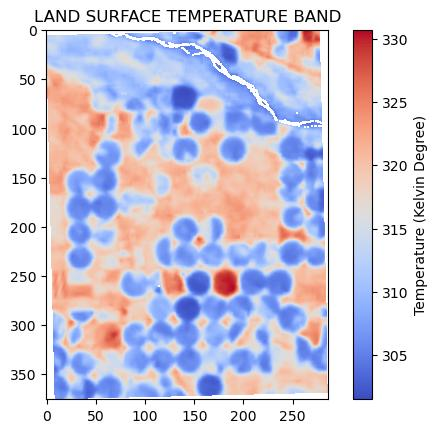

In [37]:
# Get the file path or URL of the LST raster
LST = rio.open_rasterio(run.output["lst"][0].raster_asset.path_or_url)
mask = process_buffer_geometry(geom, LST)

# Plot the masked data within the buffer area
plt.imshow(mask, cmap='coolwarm')
plt.title("LAND SURFACE TEMPERATURE BAND")
colorbar = plt.colorbar()
colorbar.set_label("Temperature (Kelvin Degree)")
lw_plot()

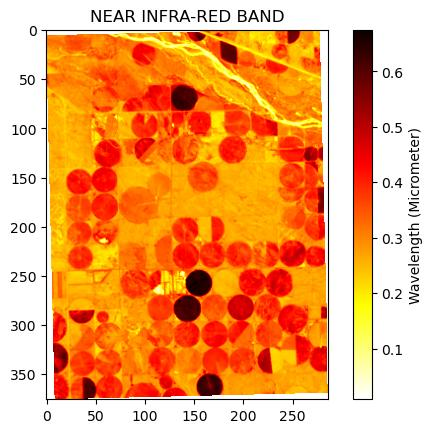

In [38]:
# Get the file path or URL of the raster
landsat = rio.open_rasterio(run.output["landsat_bands"][0].raster_asset.path_or_url)
bands_id = run.output["landsat_bands"][0].bands
NIR = landsat[bands_id["nir"]:bands_id["nir"]+1]
NIR = (NIR*0.0000275) - 0.2
NIR_mask = process_buffer_geometry(geom, NIR)

# Plot the Green Band within the buffer area
plt.imshow(NIR_mask, cmap='hot_r')
plt.title("NEAR INFRA-RED BAND")
colorbar = plt.colorbar()
colorbar.set_label("Wavelength (Micrometer)")
lw_plot()

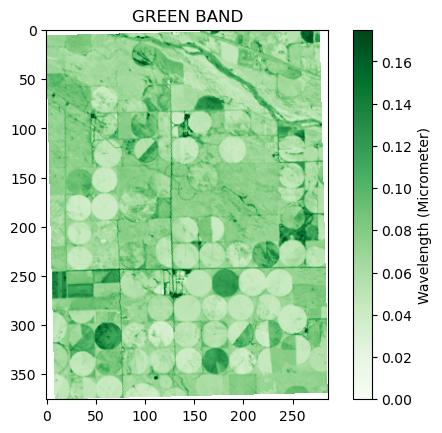

In [39]:
# Get the file path or URL of the raster
landsat = rio.open_rasterio(run.output["landsat_bands"][0].raster_asset.path_or_url)
bands_id = run.output["landsat_bands"][0].bands
Green = landsat[bands_id["green"]:bands_id["green"]+1]
Green = (Green*0.0000275) - 0.2
Green_mask = process_buffer_geometry(geom, Green)

# Plot the Green Band within the buffer area
plt.imshow(Green_mask, cmap='Greens', vmin=0, vmax=0.175)
plt.title("GREEN BAND")
colorbar = plt.colorbar()
colorbar.set_label("Wavelength (Micrometer)")
lw_plot()

6. Similarly, the above executed workflow retrieves land surface elevation data of the area, which can be viewed by executing the cell below.

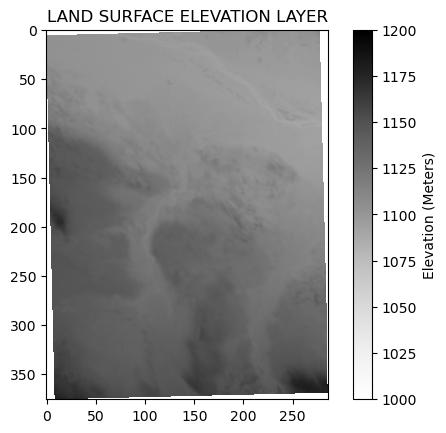

In [40]:
# Get the file path or URL of the DEM raster
DEM = rio.open_rasterio(run.output["dem"][0].raster_asset.path_or_url)
mask = process_buffer_geometry(geom, DEM)

# Plot the masked data within the buffer area
plt.imshow(mask, cmap="Greys", vmin=1000, vmax=1200)
plt.title("LAND SURFACE ELEVATION LAYER")
colorbar = plt.colorbar()
colorbar.set_label("Elevation (Meters)")
lw_plot()

## Stage 2: Indices Generation

### 1. NDVI Index:

In this stage, the workflow generates Normalized Difference Vegetation Index (NDVI) layer by applying another operation that separately retrieves Landsat 8 imagery bands and utilizes NIR and Red bands. 

This index holds significant importance as a monitoring tool for vegetation and irrigation. It has been extensively studied as a diagnostic indicator for assessing the phenological development and health of crops. Due to its relevance in evaluating crop health, this index has been incorporated into the Irrigation Classification model to maximize its benefits. 

The NDVI layer can be viewed by executing the cell below.



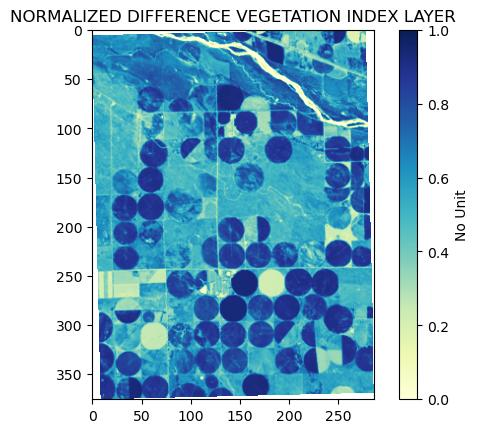

In [41]:
# Get the file path or URL of the NDVI raster
NDVI = rio.open_rasterio(run.output["ndvi"][0].raster_asset.path_or_url)
mask = process_buffer_geometry(geom, NDVI)

# Plot the masked data within the buffer area
plt.imshow(mask, cmap="YlGnBu", vmin=0, vmax=1)
plt.title("NORMALIZED DIFFERENCE VEGETATION INDEX LAYER")
colorbar = plt.colorbar()
colorbar.set_label("No Unit")
lw_plot()

### 2. Green Index:

The workflow utilizing the retrieved NIR and Green bands creates a Green Index (GI) which is a ratio between NIR and Green Bands.

GI is described as the most sensitive index to crop phenological development. This is due to adequately high absorption of light in green spectrum which generates high GI to chlorophyll content. It also does not have the issue of index saturation. To exploit this quality of GI, it is included in the irrigation classification model.



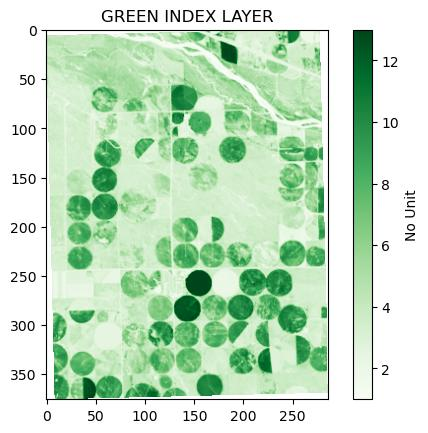

In [42]:
GI = NIR_mask/Green_mask

# Plot the masked data within the buffer area
plt.imshow(GI, cmap="Greens", vmin=1.0, vmax=13)
plt.title("GREEN INDEX LAYER")
colorbar = plt.colorbar()
colorbar.set_label("No Unit")
lw_plot()

### 3. Cloud Water Mask:

 The workflow creates a cloud water mask that utilizes the QA_PIXEL band of the satellite image and NDVI layer. This mask is employed to identify and remove pixels contaminated with cloudy area and water bodies from the satellite image during the application of irrigation classification model.

The cloud water mask generated by workflow can be viewed by executing the cell below.

*Note: Pixels with value 0 are the ones contaminated with cloud and water. Pixels with value 1 are the pixels with clear sky and without water bodies*  

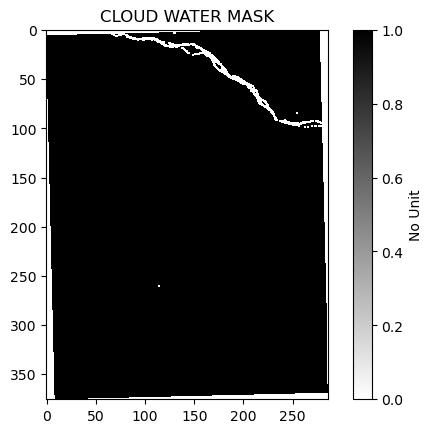

In [43]:
# Get the file path or URL of the Cloud Water Mask raster
Cloud_Water_Mask = rio.open_rasterio(run.output["cloud_water_mask"][0].raster_asset.path_or_url)
mask = process_buffer_geometry(geom, Cloud_Water_Mask)

# Plot the masked Cloud Water Mask within the buffer area
plt.imshow(mask, cmap='binary', vmin=0, vmax=1)
plt.title("CLOUD WATER MASK")
colorbar = plt.colorbar()
colorbar.set_label("No Unit")
lw_plot()

### 4. Evaporative Fraction Index:

 Another index that is generated by workflow is the Evaporative Fraction (ETRF). The incorporation of the ETRF index into the classification model helps in considering soil moisture stress, as well as the exchange of energy and mass between the vegetation surface and the atmosphere across both irrigated and non-irrigated areas. The ETRF index offers a comprehensive evaluation of soil moisture availability in meeting the evaporative demand of the atmosphere over the vegetation surface. Notably, the thermal signatures exhibit distinct characteristics indicating stress caused by either insufficient soil moisture in non-irrigated surfaces or adequate soil moisture in irrigated surfaces.

 The ETRF index generated by workflow can be viewed by executing the cell below.

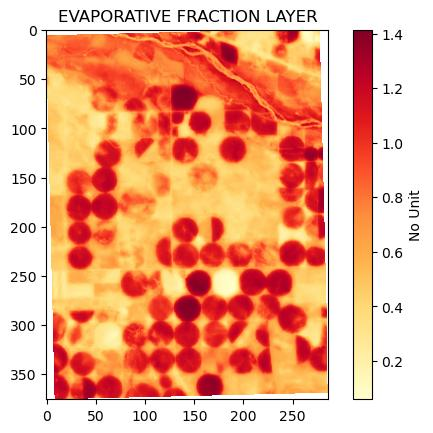

In [44]:
# Get the file path or URL of the ETRF raster
ETRF = rio.open_rasterio(run.output["evaporative_fraction"][0].raster_asset.path_or_url)
mask = process_buffer_geometry(geom, ETRF)

# Plot the masked ETRF within the buffer area
plt.imshow(mask, cmap="YlOrRd")
plt.title("EVAPORATIVE FRACTION LAYER")
colorbar = plt.colorbar()
colorbar.set_label("No Unit")
lw_plot()

## Stage 3: Irrigation Layers Calculation

### 1. NGI Layer:

NGI layer is derived by multiplying NDVI and GI indices, and is purely related to crop phenology. It provides a distinction between cropland that is irrigated and cropland that is not irrigated.

The NGI layer produced in this workflow can be viewed by executing the cell below.

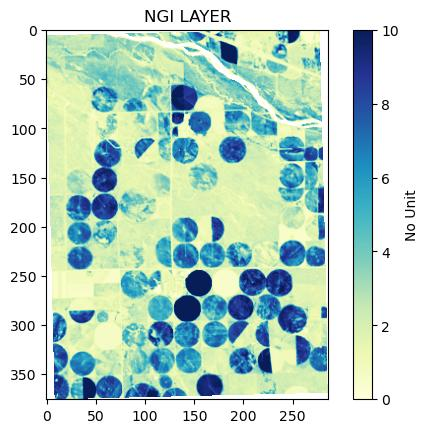

In [45]:
# Get the file path or URL of the ETRF raster
NGI = rio.open_rasterio(run.output["ngi"][0].raster_asset.path_or_url)
mask = process_buffer_geometry(geom, NGI)

# Plot the masked ETRF within the buffer area
plt.imshow(mask, cmap='YlGnBu', vmin=0, vmax=10)
plt.title("NGI LAYER")
colorbar = plt.colorbar()
colorbar.set_label("No Unit")
lw_plot()

### 2. EGI Layer:

EGI layer is derived by dividing ETRF index with GI index, and is related to both crop phenology and soil water stress. Therefore, in addition to classifying irrigation based on long term cumulative vegetation development difference as NGI layer, EGI layer can also classify irrigation based on short term soil water stress difference between irrigated and non-irrigated crops. The short term ability based on soil water stress enhances the implementation of irrigation classification model in humid climate and wet growing seasons as well.

The EGI layer derived by the workflow can be viewed by executing the cell below.

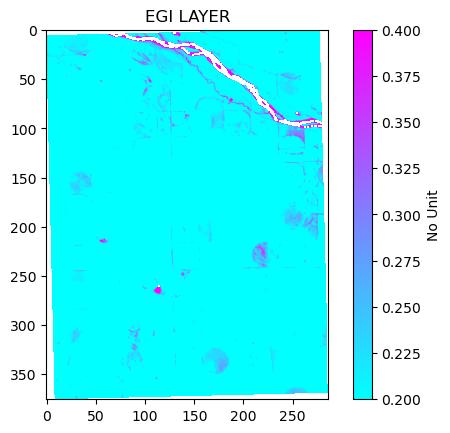

In [46]:
# Get the file path or URL of the ETRF raster
EGI = rio.open_rasterio(run.output["egi"][0].raster_asset.path_or_url)
mask = process_buffer_geometry(geom, EGI)

# Plot the masked ETRF within the buffer area
plt.imshow(mask, cmap='cool', vmin=0.2, vmax=0.4)
plt.title("EGI LAYER")
colorbar = plt.colorbar()
colorbar.set_label("No Unit")
lw_plot()

## Stage 4: Irrigation Probability Map Development

In the last stage, the workflow deploys an operation where a logistic regression model is applied to the developed NGI and EGI layers along with LST band. First,  the data from these three layers are scaled and then an optimized logistic regression model is applied to these layers. The hyper-parameters of model were calibrated to the agricultural fields of Nebraska for the year 2015.

The output of the model is a map with probability values associated with every pixels of being in irrigated condition. The irrigation probability map developed by the workflow can be viewed by executing the cell below.

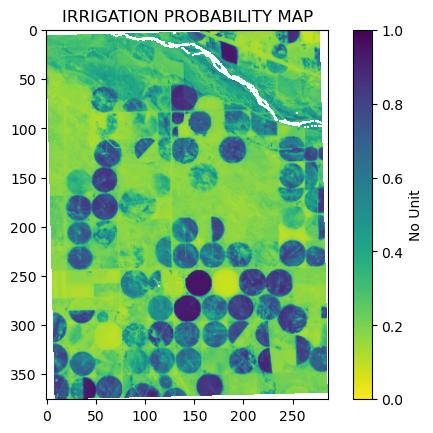

In [47]:
# Get the file path or URL of the irrigation_probability
Irr_Prob = rio.open_rasterio(run.output["irrigation_probability"][0].raster_asset.path_or_url)
mask = process_buffer_geometry(geom, Irr_Prob)

# Plot the masked Cloud Water Mask within the buffer area
plt.imshow(mask, cmap='viridis_r', vmin=0, vmax=1)
plt.title("IRRIGATION PROBABILITY MAP")
colorbar = plt.colorbar()
colorbar.set_label("No Unit")
lw_plot()